<a href="https://colab.research.google.com/github/narendra974/insidedeeplearning/blob/main/AutoEncoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader
from tqdm.autonotebook import tqdm
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def moveTo(obj, device):
  if hasattr(obj,"to"):
    return obj.to(device)
  elif isinstance(obj, list):
    return [moveTo(x, device) for x in obj]
  elif isinstance(obj, tuple):
    return tuple(moveTo(list(obj), device))
  elif isinstance(obj, set):
    return set(moveTo(list(obj), device))
  elif isinstance(obj, dict):
    to_ret = dect()
    for key, value in obj.items():
      to_ret[moveTo(key, device)] = moveTo(value,device)
    return to_ret
  else:
    return object


def run_epoch(model, optimizer, data_loader, loss_func, device, results, score_funcs, prefix="", desc=None):
    """
    model -- the PyTorch model / "Module" to run for one epoch
    optimizer -- the object that will update the weights of the network
    data_loader -- DataLoader object that returns tuples of (input, label) pairs. 
    loss_func -- the loss function that takes in two arguments, the model outputs and the labels, and returns a score
    device -- the compute lodation to perform training
    score_funcs -- a dictionary of scoring functions to use to evalue the performance of the model
    prefix -- a string to pre-fix to any scores placed into the _results_ dictionary. 
    desc -- a description to use for the progress bar.     
    """
    running_loss = []
    y_true = []
    y_pred = []
    start = time.time()
    for inputs, labels in tqdm(data_loader, desc=desc, leave=False):
        #Move the batch to the device we are using. 
        inputs = moveTo(inputs, device)
        labels = moveTo(labels, device)
        y_hat = model(inputs) #this just computed f_Θ(x(i))
        # Compute loss.

        loss = loss_func(y_hat, labels)

        if model.training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #Now we are just grabbing some information we would like to have
        running_loss.append(loss.item())

        if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
            #moving labels & predictions back to CPU for computing / storing predictions
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            #add to predictions so far
            y_true.extend(labels.tolist())
            y_pred.extend(y_hat.tolist())
    #end training epoch
    end = time.time()
    
    y_pred = np.asarray(y_pred)
    if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
        y_pred = np.argmax(y_pred, axis=1)
    #Else, we assume we are working on a regression problem
    
    results[prefix + " loss"].append( np.mean(running_loss) )
    for name, score_func in score_funcs.items():
        try:
            results[prefix + " " + name].append( score_func(y_true, y_pred) )
        except:
            results[prefix + " " + name].append(float("NaN"))
    return end-start #time spent on epoch


def train_simple_network(model, loss_func, train_loader, test_loader=None, score_funcs=None, 
                         epochs=50, device="cpu", checkpoint_file=None, lr=0.001):
    """Train simple neural networks
    
    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs. 
    test_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training
    
    """
    to_track = ["epoch", "total time", "train loss"]
    if test_loader is not None:
        to_track.append("test loss")
    if score_funcs is not None:
      for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if test_loader is not None:
            to_track.append("test " + eval_score )
        
    total_train_time = 0 #How long have we spent in the training loop? 
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []
        
    #SGD is Stochastic Gradient Decent.
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
        model = model.train()#Put our model in training mode
        
        total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")

        results["total time"].append( total_train_time )
        results["epoch"].append( epoch )
        
        if test_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing")
                    
    if checkpoint_file is not None:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'results' : results
            }, checkpoint_file)

    return pd.DataFrame.from_dict(results)


def train_network(model, loss_func, train_loader, val_loader=None, test_loader=None,score_funcs=None, 
                         epochs=50, device="cpu", checkpoint_file=None, 
                         lr_schedule=None, optimizer=None, disable_tqdm=False
                        ):
    """Train simple neural networks
    
    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs. 
    val_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    test_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training
    lr_schedule -- the learning rate schedule used to alter \eta as the model trains. If this is not None than the user must also provide the optimizer to use. 
    optimizer -- the method used to alter the gradients for learning. 
    
    """
    if score_funcs == None:
        score_funcs = {}#Empty set 
    
    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    if test_loader is not None:
        to_track.append("test loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if val_loader is not None:
            to_track.append("val " + eval_score )
        if test_loader is not None:
            to_track.append("test "+ eval_score )
        
    total_train_time = 0 #How long have we spent in the training loop? 
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []

        
    if optimizer == None:
        #The AdamW optimizer is a good default optimizer
        optimizer = torch.optim.AdamW(model.parameters())
        del_opt = True
    else:
        del_opt = False

    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch", disable=disable_tqdm):
        model = model.train()#Put our model in training mode

        total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")
        
        results["epoch"].append( epoch )
        results["total time"].append( total_train_time )
        
      
        if val_loader is not None:
            model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!
            with torch.no_grad():
                run_epoch(model, optimizer, val_loader, loss_func, device, results, score_funcs, prefix="val", desc="Validating")
                
        #In PyTorch, the convention is to update the learning rate after every epoch
        if lr_schedule is not None:
            if isinstance(lr_schedule, torch.optim.lr_scheduler.ReduceLROnPlateau):
                lr_schedule.step(results["val loss"][-1])
            else:
                lr_schedule.step()
                
        if test_loader is not None:
            model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing")
        
        
        if checkpoint_file is not None:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results' : results
                }, checkpoint_file)
    if del_opt:
        del optimizer

    return pd.DataFrame.from_dict(results)


def prediction(model, img):
  with torch.no_grad():
    w, h = img.shape
    if not isinstance(img, torch.Tensor):
      img = torch.tensor(img)
    x = img.reshape(1, -1, w, h)
    logits = model(x)
    y_hat = F.softmax(logits, dim=1)
    return y_hat.numpy().flatten()

In [2]:
D = 28 * 28
n = 2
C = 1

classes = 10

In [3]:
class TransposeLinear(nn.Module):

  def __init__(self, linearLayer, bias=True):
    super().__init__()
    self.weight = linearLayer.weight
    if bias:
      self.bias = nn.Parameter(torch.Tensor(linearLayer.weight.shape[1]))
    else:
      self.register_parameter('bias', None)

  def forward(self, x):
    return F.linear(x, self.weight.t(), self.bias)

In [4]:
class View(nn.Module):
  def __init__(self, *shape):
    super(View, self).__init__()
    self.shape=shape

  def forward(self, input):
    return input.view(*self.shape)

In [5]:
linearLayer = nn.Linear(D, n, bias=False)
pca_encoder = nn.Sequential(
   nn.Flatten(),
   linearLayer
)

pca_decoder = nn.Sequential(
    TransposeLinear(linearLayer, bias=False),
    View(-1, 1, 28,28)
)

pca_model = nn.Sequential(
    pca_encoder, 
    pca_decoder
)

In [6]:
nn.init.orthogonal(linearLayer.weight)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  """Entry point for launching an IPython kernel.


Parameter containing:
tensor([[ 0.0027,  0.0362,  0.0334,  ..., -0.0307,  0.0177,  0.0448],
        [-0.0217,  0.0559,  0.0132,  ...,  0.0049, -0.0639,  0.0490]],
       requires_grad=True)

In [7]:
mse_loss = nn.MSELoss()

def mseWithOrthoLoss(x, y):
  W = linearLayer.weight
  I = torch.eye(W.shape[0]).to(device)
  normal_loss = mse_loss(x,y)

  regularization_loss = 0.1 * mse_loss(torch.mm(W, W.t()), I)
  return normal_loss + regularization_loss

In [8]:
class AutoEncoderDataset(Dataset):

  def __init__(self, dataset):
    self.dataset = dataset

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    x,y = self.dataset.__getitem__(idx)
    return x, x

In [9]:
import torchvision

train_data = AutoEncoderDataset(torchvision.datasets.MNIST("./",train=True, transform=ToTensor(), download=True))
test_data_xy = torchvision.datasets.MNIST("./",train=False, transform=ToTensor(), download=True)
test_data_xx = AutoEncoderDataset(torchvision.datasets.MNIST("./",train=False, transform=ToTensor(), download=True))

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data_xx, batch_size=128)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [10]:
train_network(pca_model, mseWithOrthoLoss, train_loader, test_loader=test_loader, epochs=10, device=device)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

,epoch,total time,train loss,test loss
0,0,13.244815,0.064228,0.057975
1,1,26.073454,0.057974,0.057822
2,2,32.569681,0.057887,0.057805
3,3,39.406834,0.057885,0.057784
4,4,46.588307,0.057888,0.057857
5,5,53.735505,0.057889,0.057874
6,6,60.857689,0.057891,0.057808
7,7,69.111843,0.057890,0.057778
8,8,81.432031,0.057887,0.057824
9,9,89.408428,0.057891,0.057888


In [11]:
def encode_batch(encoder, dataset_to_encode):

  projected = []
  labels = []

  encoder = encoder.eval()
  encoder = encoder.cpu()

  with torch.no_grad():
    for x, y in DataLoader(dataset_to_encode, batch_size=128):
      z=encoder(x.cpu())
      projected.append(z.numpy())
      labels.append(y.cpu().numpy().ravel())
  projected = np.vstack(projected)
  labels = np.hstack(labels)
  return projected, labels




(10000, 2)
(10000,)


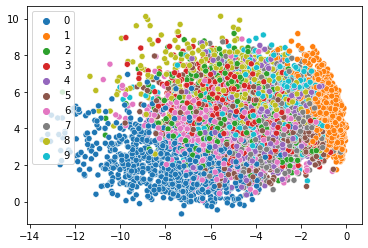

In [12]:
import seaborn as sns

projected, labels = encode_batch(pca_encoder, test_data_xy)
print(projected.shape)
print(labels.shape)
sns.scatterplot(x=projected[:, 0], y=projected[:, 1], hue=[str(l) for l in labels], hue_order=[str(i) for i in range(10)], legend="full")


In [13]:
def showEncodeDecode(encode_decode, x):
  encode_decode = encode_decode.eval()
  encode_decode = encode_decode.cpu()

  with torch.no_grad():
    x_recon = encode_decode(x)
  
  f, axarr = plt.subplots(1, 2)
  axarr[0].imshow(x.numpy()[0, :])
  axarr[1].imshow(x_recon.numpy()[0, 0, :])


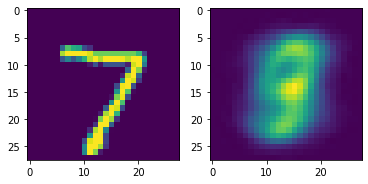

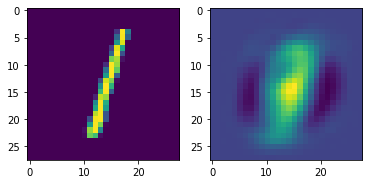

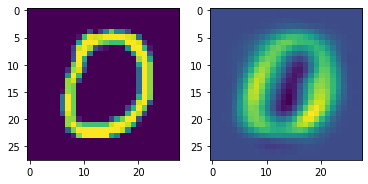

In [14]:
showEncodeDecode(pca_model, test_data_xy[0][0])
showEncodeDecode(pca_model, test_data_xy[2][0])
showEncodeDecode(pca_model, test_data_xy[10][0])

In [16]:
pca_nonlinear_encode = nn.Sequential(
    nn.Flatten(),
    nn.Linear(D, n), 
    nn.Tanh()
)

pca_nonlinea_decode = nn.Sequential(
    nn.Linear(n, D),
    View(-1, 1, 28, 28)
)

pca_nonlinear= nn.Sequential(
    pca_nonlinear_encode,
    pca_nonlinea_decode
)


In [17]:
train_network(pca_nonlinear, mse_loss, train_loader, test_loader=test_loader, epochs=10, device=device)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

,epoch,total time,train loss,test loss
0,0,6.907880,0.131096,0.068729
1,1,13.674455,0.066406,0.066020
2,2,19.991643,0.065556,0.065418
3,3,27.101090,0.064818,0.064487
4,4,37.326928,0.063660,0.063061
5,5,44.876099,0.062122,0.061418
6,6,52.860827,0.060609,0.060016
7,7,59.470002,0.059469,0.059048
8,8,65.953669,0.058702,0.058388
9,9,72.647173,0.058226,0.058018


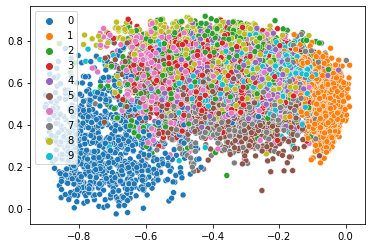

In [18]:
projected, labels = encode_batch(pca_nonlinear_encode, test_data_xy)
sns.scatterplot(x=projected[:, 0], y=projected[:, 1], hue=[str(l) for l in labels], hue_order=[str(i) for i in range(10)], legend="full")